# Credit Risk Analysis

### Getting Workspace Ready & Exploring Data

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
loans = pd.read_csv("Task 3 and 4_Loan_Data.csv")
loans[:10]

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
5,4661159,0,5376.886873,7189.121298,85529.84591,2,697,0
6,8291909,1,3634.057471,7085.980095,68691.57707,6,722,0
7,4616950,4,3302.172238,13067.570210,50352.16821,3,545,1
8,3395789,0,2938.325123,1918.404472,53497.37754,4,676,0
9,4045948,0,5396.366774,5298.824524,92349.55399,2,447,0


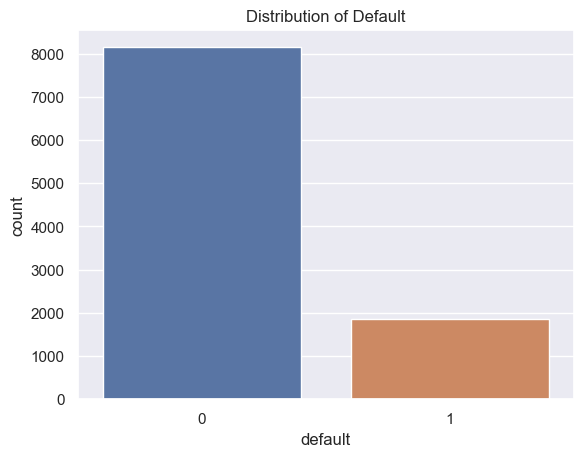

In [3]:
sns.set()
sns.countplot(x = "default", data = loans)
plt.title("Distribution of Default");

From the 10,000 different customers, just under 20% of them have defaulted in the past.

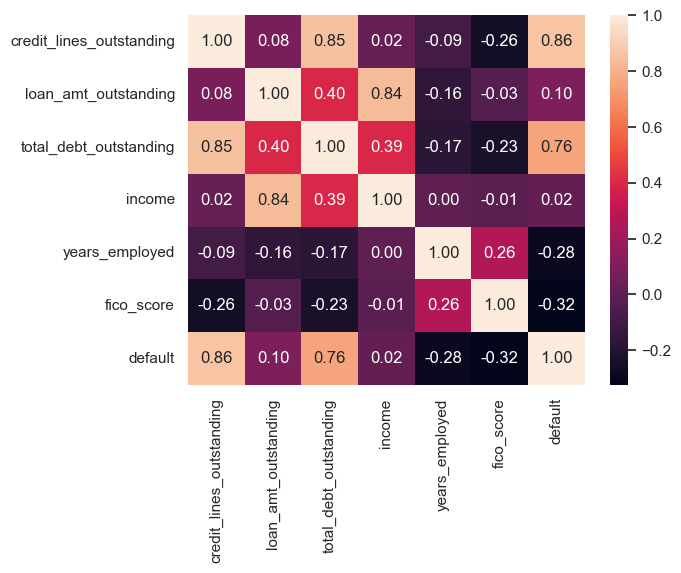

In [4]:
data = loans.drop("customer_id", axis = 1)
corr_mat = data.corr()
sns.heatmap(corr_mat, annot = True, fmt = ".2f");

All of the money based variables seem to be strongly correlated. 

### Modeling

In [37]:
# Importing libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix

In [38]:
# Feature Selection
X = data.drop("default", axis = 1)
y = data["default"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 66)

In [39]:
# Initialzing models
lr = LogisticRegression()
rf = RandomForestClassifier()
xg = XGBClassifier()

In [40]:
# Training models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [41]:
# Model predicitons
lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)
xg_pred = xg.predict(X_test)

In [42]:
# Logistic Regression Evaluation
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1638
           1       0.97      0.96      0.97       362

    accuracy                           0.99      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



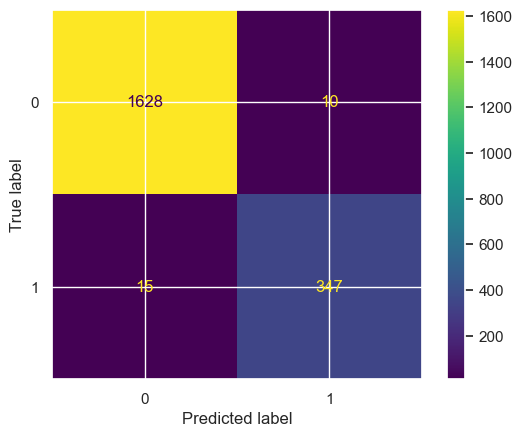

In [43]:
cm_lr = confusion_matrix(y_test, lr_pred)
dis_lr = ConfusionMatrixDisplay(cm_lr, display_labels = lr.classes_)
dis_lr.plot()

In [44]:
# Random Forest Evaluation
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1638
           1       0.99      0.99      0.99       362

    accuracy                           1.00      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



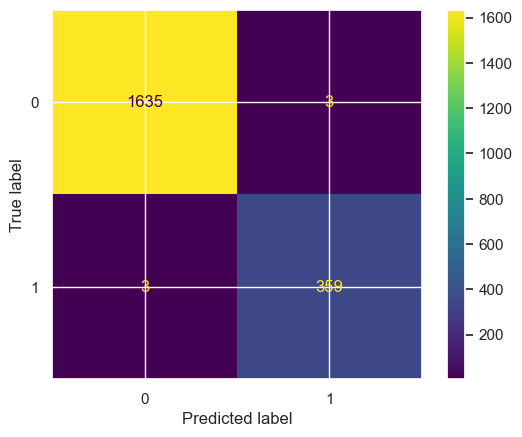

In [45]:
cm_rf = confusion_matrix(y_test, rf_pred)
dis_rf = ConfusionMatrixDisplay(cm_rf, display_labels = rf.classes_)
dis_rf.plot()

In [46]:
# XGBoost Evaluation
print(classification_report(y_test, xg_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1638
           1       0.99      0.99      0.99       362

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



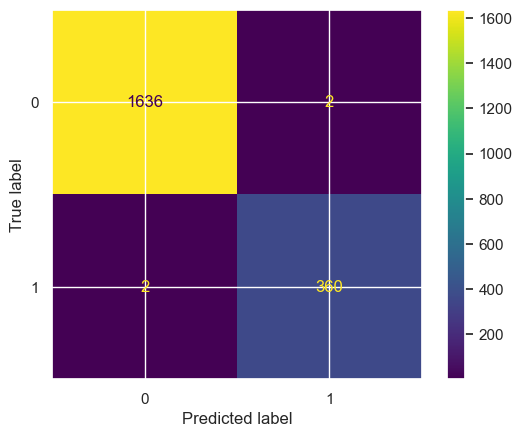

In [47]:
cm_xg = confusion_matrix(y_test, xg_pred)
dis_xg = ConfusionMatrixDisplay(cm_xg, display_labels = xg.classes_)
dis_xg.plot()

It looks like overall, the XGBoost model is performing the best. It is achieving the highest overall accuracy, as well as the lowest false positive and false negative rates. Let's check out how its ROC/AUC curve looks like.

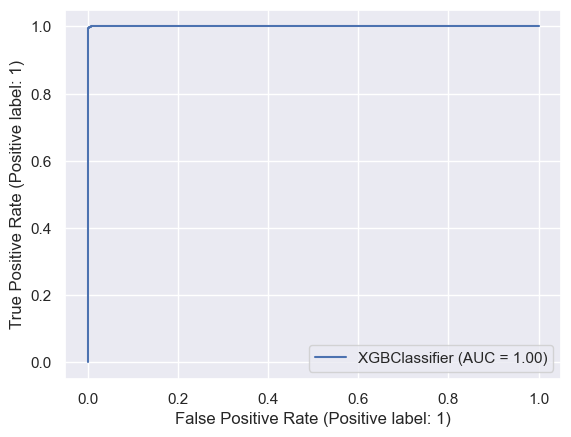

In [48]:
RocCurveDisplay.from_estimator(estimator = xg, X = X_test, y = y_test);

This model is pretty much performing perfectly, so we will continue with it.

### Function for Probability of Default

In [86]:
def predict_default(borrower_data, model = xg):
    borrower_data = pd.DataFrame(borrower_data).transpose()
    pd_result = model.predict_proba(borrower_data)[:, 1]
    return pd_result

In [87]:
def expected_loss(pd, loan_amount, recovery_rate = 0.1):
    return pd * loan_amount * (1 - recovery_rate)

In [88]:
# Example usage
data_in = data.drop("default", axis = 1)
pd_result = predict_default(data_in.iloc[100])
el = expected_loss(pd_result, data_in.loan_amt_outstanding[100])
print(f"Probability of Default: {pd_result}")
print(f"Expected Loss: ${el}")

Probability of Default: [0.99999046]
Expected Loss: $[4434.0254]


In [89]:
# Actual Data
data.iloc[100]

credit_lines_outstanding        5.000000
loan_amt_outstanding         4926.741674
total_debt_outstanding      18943.139780
income                      72136.006220
years_employed                  4.000000
fico_score                    622.000000
default                         1.000000
Name: 100, dtype: float64